# 数据读取

正如其GitHub页面(https://github.com/yzhao062/pyod) 上的标语所说，“Python异常值检测模块是一个全面且可扩展的Python库，用于异常值检测（异常检测）”。PyOD为55多个算法提供统一的API，并不断扩展。自2017年推出以来，它受到了广泛关注，已经下载了800多万次。主要贡献者是Yue Zhao，Zain Nasrullah和Zheng Li。

In [1]:
import pandas as pd
import numpy as np
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

使用数据生成过程（DGP）来模拟500个观测值和六个变量。将异常值的百分比设置为5%。模拟数据有目标变量Y。将只使用X数据进行无监督模型OCSVM。

In [2]:
contamination = 0.05  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 6  # number of features
X_train, X_test, y_train, y_test = generate_data(n_train=n_train,
                                                 n_test=n_test,
                                                 n_features=n_features,
                                                 contamination=contamination,
                                                 random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


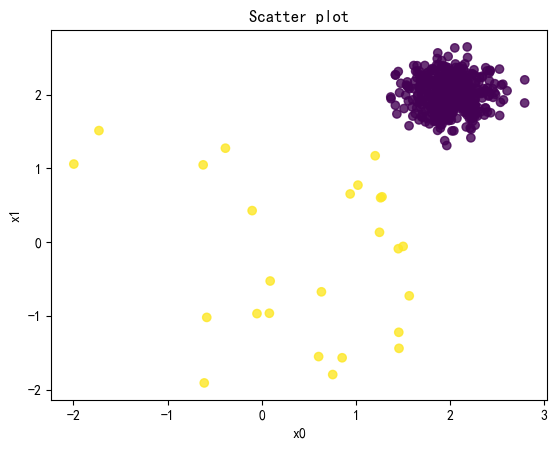

In [3]:
# 以散点图的形式绘制了前两个变量。黄色点是异常值，紫色点是正常数据点。
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

# 检测方法

## HBOS

### 算法原理

基于这种直觉，可以使用变量的直方图来定义变量的单变量异常值分数。一个观察结果应该有N个单变量异常值分数。该技术假设变量之间是独立的，以推导直方图和单变量异常值分数。一个观察结果的N个单变量异常值分数可以加总成为基于直方图的异常值分数（HBOS）。尽管这个假设听起来很强，但HBOS在实际情况中证明了其有效性。

HBOS独立地为所有的N个变量构建直方图。箱子的高度用于衡量“异常性”。大多数观察结果属于高频箱子，而异常值属于低频箱子。单变量异常值分数被定义为箱子高度的倒数。

## ECOD

### 算法原理

基于经验累积分布的异常检测（ECOD）具有非常直观的方法：异常值是分布尾部的罕见事件，可以通过测量分布中的位置来识别。

ECOD首先以非参数方式估计变量的分布。然后，它将所有维度的估计尾部概率相乘，以获得观测值的异常得分。从数学上讲，很难估计多个维度的联合分布。ECOD假设变量独立，因此可以估计每个变量的经验累积分布。尽管变量独立的假设可能过于严格，但这并不是新的，因为前一章中的HBOS也做出了相同的假设，并且已被证明是有效的。

为了解释“非参数”和“参数”这些术语，甚至有助于澄清一些相关术语“总体”、“样本”和“估计”。统计学的目标是了解我们感兴趣的“总体”。诸如均值、标准差和比例之类的数量被称为描述总体的“参数”。我们通常无法获取整个总体的所有数据，因此无法计算描述总体的参数。一个实际的解决方案是收集随机的“样本”来描述总体。样本的分布使我们能够对总体的分布进行“估计”。

“参数化”方法对底层总体的分布形状（如正态分布）做出假设。“非参数化”方法不对总体分布的形状和参数做任何假设。分布将从样本中“经验性”地估计。

## KNN

### 算法原理

由于异常值是远离邻近点的点，因此异常分数被定义为到其第k个最近邻居的距离。每个点都有一个异常分数。我们的任务是找出那些具有高异常分数的点。

PyOD中的KNN方法使用三种类型的距离度量之一作为异常分数：最大值（默认）、平均值和中位数。"最大值"使用到k个邻居的最大距离作为异常分数。"平均值"和"中位数"分别使用平均值和中位数作为异常分数。

### 构建模型

In [30]:
from pyod.models.knn import KNN

knn = KNN(contamination=0.05)
knn.fit(X_train)

# Training data
y_train_scores = knn.decision_function(X_train) # 异常分数
y_train_pred = knn.predict(X_train)

# Test data
y_test_scores = knn.decision_function(X_test)
y_test_pred = knn.predict(X_test)  # outlier labels (0 or 1)


def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))


print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:", knn.threshold_)

The training data: {0: 475, 1: 25}
The testing data: {0: 475, 1: 25}
The threshold for the defined comtanimation rate: 0.7566127656515499


In [31]:
knn.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

### 模型聚合

In [32]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
k_list = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170,
    180, 190, 200
]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

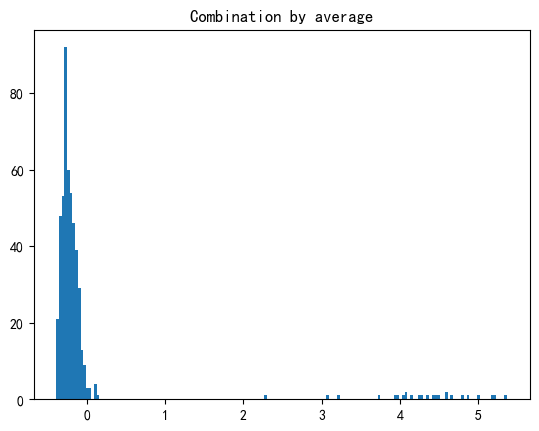

In [33]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns.
# The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt

plt.hist(y_train_by_average,
         bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

无监督的k-NN方法计算观测值与其他观测值之间的欧氏距离。无监督的KNN没有任何参数可以调整以提高性能。它只是计算邻居之间的距离。

KNN的异常值分数定义为与其第k个最近邻的距离。

## IForest

### 算法原理

许多离群值检测方法首先对正常数据点进行建模，然后识别那些不符合正常数据模式的观测值。孤立森林（Isolation Forest）或IForest，由Liu, Ting, and Zhou (2008)提出，与这些方法不同。孤立森林不是通过对正常数据点进行建模来寻找离群值，而是直接识别异常值。它应用了一种树结构来隔离每个观测值。离群值将首先被单独分离出来，而正常点往往隐藏在树的深处。他们将每棵树称为孤立树（Isolation Tree）或iTree。他们的算法构建了一组iTree。在iTree上，路径长度较短的观测值被视为异常值。

图（A）使用分区图和树来解释iTree如何隔离数据点。红点是离其他点最远的，然后是绿点，然后是蓝点。在分区图中，只需要一次“切割”就可以将红点与其他点分离。第二次切割是为了绿点，第三次切割是为了蓝点，依此类推。分离一个点所需的切割次数越多，它在树中的深度越深。切割次数的倒数就是异常得分。图（A）右侧的树结构讲述了同样的故事。它需要一次分割来单独分离红点，然后是第二次分割来触及绿点，然后是第三次分割来到达蓝点，依此类推。深度的数量成为了异常得分的良好代理。为了与异常值与高得分相关的传统约定一致，异常得分被定义为深度数量的倒数。

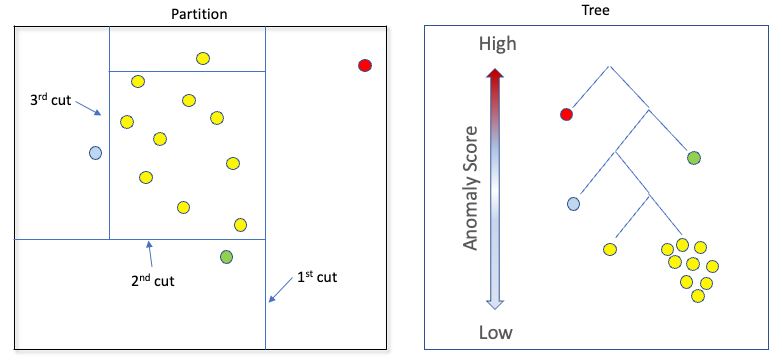

iTree是一棵二叉树，树中的每个节点都有零个或两个子节点。iTree开始生长，直到满足以下条件之一：（i）末节点只有一个数据点，（ii）节点中的所有数据具有相同的值，或者（iii）树达到研究者设置的高度限制。iTree不需要完全发展，直到所有末节点都有一个数据点。通常，当深度达到设置的限制时，它停止生长。这是因为我们对根节点附近的异常值感兴趣。因此，构建一个大的iTree并不是必要的，因为iTree中的大部分数据都是正常数据点。小样本量会产生更好的iTree，因为它可以减少淹没和掩盖效应。请注意，这个iTree算法与决策树算法不同，因为iTree不使用目标变量来训练树。它是一种无监督学习方法。

### 构建模型

In [35]:
from pyod.models.iforest import IForest

isft = IForest(contamination=0.05, max_samples=40, behaviour='new')
isft.fit(X_train)

# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test)  # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:", isft.threshold_)


def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))


print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: -4.864164626638967e-15
The training data: {0: 475, 1: 25}
The testing data: {0: 475, 1: 25}


In [36]:
isft_vi = isft.feature_importances_
isft_vi

array([0.15194461, 0.18338716, 0.16363394, 0.18199359, 0.14724661,
       0.17179409])

我们可以像树模型一样绘制特征重要性。图显示了确定异常值的特征的相对强度。

<Axes: >

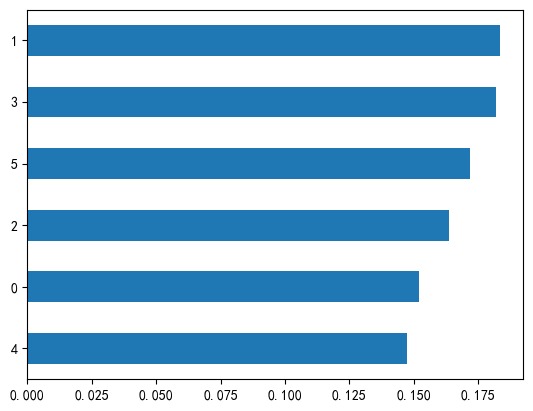

In [37]:
for_plot = pd.DataFrame({
    'x_axis': X_train_pd.columns,
    'y_axis': isft_vi
}).sort_values(by='y_axis', ascending=True)
for_plot['y_axis'].plot.barh()

### 确定阈值

阈值将由异常值分数的直方图确定。图建议将阈值设置在0.0左右。这意味着大多数正常数据的异常值分数小于0.0。异常数据的异常值分数处于较高的范围内。

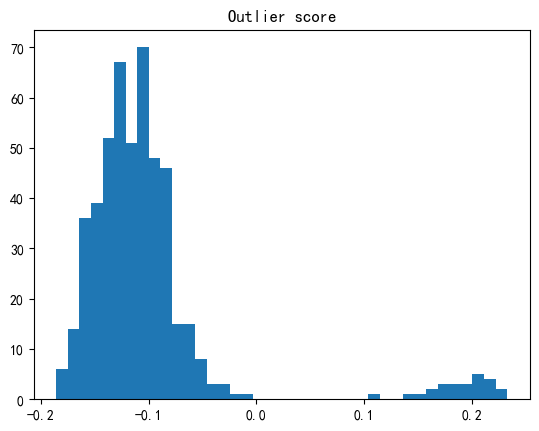

In [38]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### 模型聚合

由于IForest是一种基于相似度的算法，它对异常值非常敏感，并且容易过拟合。为了产生稳定的预测结果，我们可以聚合多个模型产生的分数。在所有超参数中，树的数量n_estimators可能是最重要的一个。我将为不同数量的树生成5个模型。这些模型的平均预测结果将作为最终的模型预测结果。PyOD模块提供了四种方法来聚合结果。记得使用pip install combo安装相关函数。你只需要使用一种方法来产生聚合结果。

In [39]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of the number of trees
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k)
    isft = IForest(contamination=0.05, n_estimators=k)
    isft.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train_norm)
    test_scores[:, i] = isft.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

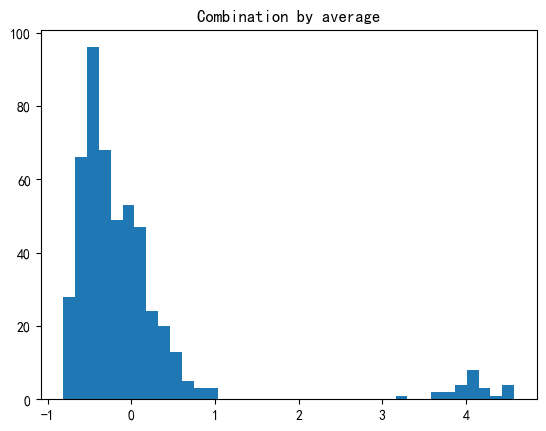

In [40]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt

plt.hist(y_train_by_average,
         bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

大多数现有的基于模型的异常检测方法会构建一个正常实例的概要，然后将不符合正常概要的实例标识为异常值。但是，Isolation Forest直接且明确地隔离异常值。

IForest采用树结构来隔离每个单独的数据点。异常值是首先被单独分离出来的单个数据点；而正常点往往在树中聚集在一起。

由于Isolation Forest不使用任何距离度量来检测异常值，因此它对于大数据量和高维问题是快速且适用的。

## LOF

### 算法原理

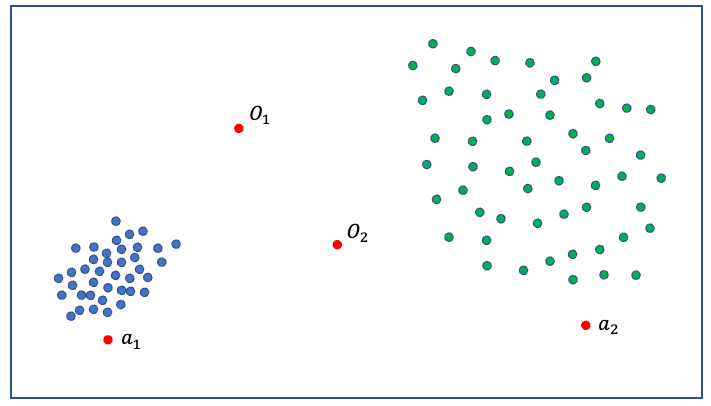

LOF计算数据点与其邻居之间的密度偏差。如果一个数据点的密度远低于其邻居，则被视为异常值。在图（A）中，点a1所在的区域比蓝色聚类中的其他点密度要低得多。在图（A）中，蓝色聚类看起来比绿色聚类更密集。当数据具有不同密度时，LOF特别有效。点a2是绿色聚类的局部异常值。LOF可以将a2识别为局部异常值。

局部离群因子（LOF）专门设计用于调整不同局部密度的变化。我将LOF的形成分为五个步骤，按顺序逐步解释LOF。在这五个步骤中，第四步是涉及局部密度的步骤。第五步是LOF，它将一个点所在位置的邻域密度与附近数据聚类的密度进行比较。

第一步：K个邻居

第二步：K距离

第三步：可达距离（RD）

第四步：局部可达密度（LRD）

第五步：K邻居的局部离群因子：LOF(k)

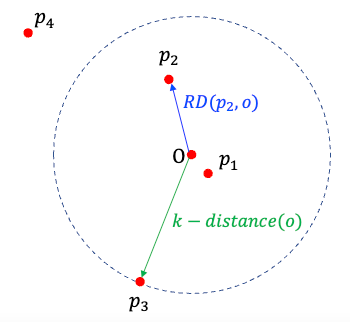

首先，K-最近邻是指到达K个最近邻居的圆形区域。在图（B）中，点O的第一个、第二个和第三个最近邻居分别是p1、p2和p3。虚线圆是当K=3时的K个最近邻居的区域。这个定义与KNN相同。

其次，K-距离（o）是从点O到K个最近邻居的距离。距离可以用欧几里得距离或曼哈顿距离来衡量。

第三，点O的可达距离是K-距离（o）和任意点P与O之间距离的最大值。在上面的图（B）中，当K=3时，K-距离是到点P3的距离。从P2到O的距离是d(P2, O)，小于点P3到O的距离，即K-距离（o）。因此，P2的可达距离是K-距离（o），即从P3到O的距离。

步骤1和2只是帮助定义步骤3中的可达性距离。可达性距离公式是为了减少与点O接近的所有点P的*d(p,o)*的统计波动。暂时只需记住它是任意点到点O的距离。可达性距离越长，点O越有可能是异常值。

在步骤4中，LRD是点O从其邻居处的平均可达性距离的倒数。LRD的低值意味着最近的数据体离点O很远。点的LRD用于与其K个邻居的平均LRD进行比较。

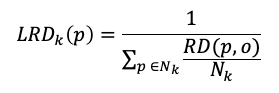

最后，在第5步中，LOF是点O的K个邻居的平均LRD与其自身LRD之比。第一项是K个邻居的平均LRD。LOF是点p的LRD与其K个最近邻居的LRD之比的平均值。第二项是点O的LRD。
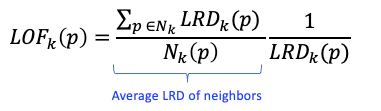

如果点O不是异常值，则邻居的平均LRD大致等于点O的LRD。点和其邻居的密度大致相等。在这种情况下，LOF几乎等于1。另一方面，如果点O是异常值，则第一项邻居的平均LRD将高于第二项。LOF将大于1。

LOF中距离比的使用确保可以考虑不同的局部密度。簇中数据点的LOF值通常接近1，而不管该簇的密度如何。例如，在图(A)中，无论是蓝色簇还是绿色簇中的数据点的LOF值都接近1，即使两个簇的密度不同。

一般来说，如果LOF> 1，则被视为异常值。该数据点与邻居的距离比预期的要远。另一方面，如果数据点位于密集的数据区域中，则不是异常值。其LOF值将接近1。

### 构建模型

In [29]:
from pyod.models.lof import LOF

lof = LOF(contamination=0.05) # 在大多数情况下，我们不知道异常值的百分比，因此可以根据任何先前的知识分配一个值
lof.fit(X_train)

# Training data
y_train_scores = lof.decision_function(X_train)
y_train_pred = lof.predict(X_train)

# Test data
y_test_scores = lof.decision_function(X_test)
y_test_pred = lof.predict(X_test)  # outlier labels (0 or 1)


def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))


print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:", lof.threshold_)

The training data: {0: 477, 1: 23}
The testing data: {0: 472, 1: 28}
The threshold for the defined comtanimation rate: 1.321258785666126


In [22]:
lof.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 20,
 'novelty': True,
 'p': 2}

### 确定阈值

PyOD有一个内置函数threshold_，它根据污染率contamination计算训练数据的阈值。由于默认的污染率是0.10，训练数据的阈值为1.2311，如下所示。它表示任何具有异常分数大于1.2311的观测值都被视为异常值。

确定阈值的第二种方法是使用PCA异常值分数的直方图，这样我们可以根据业务情况选择阈值。图©展示了分数的直方图。我们可以选择更保守的方法，选择一个较高的阈值，这将导致异常组中的异常值更少，但希望更精细。

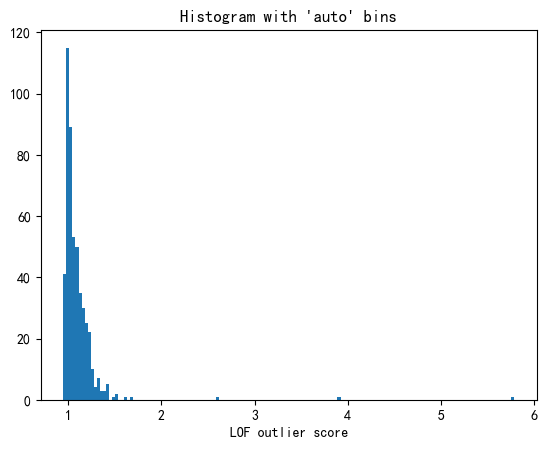

In [23]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('LOF outlier score')
plt.show()

### 描述统计

In [25]:
threshold = lof.threshold_  # Or other value from the above histogram


def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal',
                           'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(
        columns={'Anomaly_Score': 'Count'})
    cnt['Count %'] = (cnt['Count'] /
                      cnt['Count'].sum()) * 100  # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index()  # The avg.
    stat = cnt.merge(stat, left_on='Group',
                     right_on='Group')  # Put the count and the avg. together
    return (stat)


descriptive_stat_threshold(X_train, y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,477,95.4,1.94,1.92,1.90,1.89,1.92,1.9,1.07
1,Outlier,23,4.6,1.58,1.46,1.53,1.71,1.54,1.5,1.77


### 模型聚合

In [26]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.lof import LOF
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 models.
n_clf = 20
k_list = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170,
    180, 190, 200
]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    lof = LOF(n_neighbors=k)
    lof.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = lof.decision_scores_
    test_scores[:, i] = lof.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

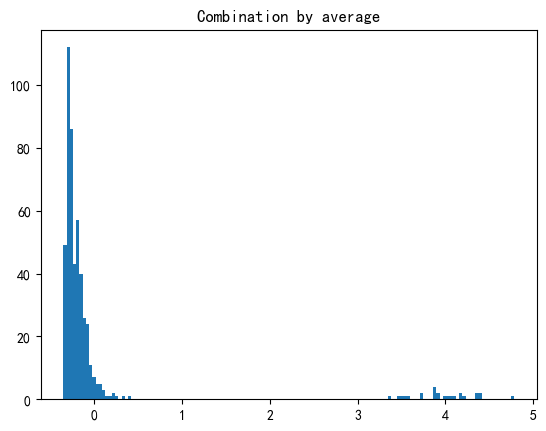

In [27]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column:
y_by_average = average(train_scores_norm)

plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

LOF是一种基于密度的技术，使用最近邻搜索来识别异常点。

通常，如果LOF> 1，则被认为是异常值。该数据点距离邻居的距离比预期更远。另一方面，如果数据点位于密集的数据区域中，则不是异常值。其LOF值将接近1。

## OCSVM

### 算法原理

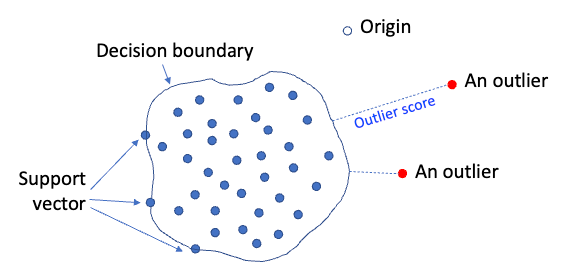

OCSVM是一种基于支持向量机的异常检测算法，它使用一个超平面来分离正常数据和异常数据。正常数据在超平面的一侧，而异常数据在另一侧。OVSVM的目标是找到一个最优的超平面，使得正常数据离超平面最远，而异常数据则尽可能靠近超平面。

OCSVM的异常得分是数据点到超平面的距离。这个距离也被称为相似度度量。相似度度量是通过N维相似度矩阵计算得出的。它是通过核函数计算得出的，例如径向基函数、线性函数、多项式函数或Sigmoid函数。径向基函数简单地计算输入x与固定点c之间的距离，例如ϕ(x)=f(‖x−c‖)。

OCSVM对核函数和一些超参数的选择非常敏感，性能可能会因选择而大幅变化。一个重要的超参数叫做**nu**，它是训练数据中数据点是异常点的概率。它是一个介于0和1之间的值。10%的nu意味着10%的数据可以被错误地分类为异常点，而支持边界上也有10%的数据。具体而言，nu是异常点比例和支持向量数量之间的权衡。

由于OCSVM对超参数非常敏感，解决方法是建立多个模型，并对预测结果进行平均，以获得稳定的结果。


### 构建模型

下面的代码指定并拟合了模型"ocsvm"。参数contamination=0.05声明了异常值的百分比为5%。这个参数不影响异常值得分的计算。如果没有指定，默认值为PyOD的10%。函数decision_function()计算观测值的异常值得分。函数predict()根据异常率分配"1"或"0"。语法.threshold_显示了分配的异常率的阈值。

In [19]:
from pyod.models.ocsvm import OCSVM
ocsvm = OCSVM(contamination=0.05)  
ocsvm.fit(X_train)

# Training data
y_train_scores = ocsvm.decision_function(X_train)
y_train_pred = ocsvm.predict(X_train)

# Test data
y_test_scores = ocsvm.decision_function(X_test)
y_test_pred = ocsvm.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ocsvm.threshold_)

The training data: {0: 475, 1: 25}
The testing data: {0: 475, 1: 25}
The threshold for the defined comtanimation rate: 29.680071121036956


In [20]:
# 通过.get_params()来打印超参数的值
ocsvm.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'contamination': 0.05,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.5,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### 确定阈值

因为异常值分数衡量了异常值与正常数据点之间的偏差，我们可以使用异常值分数的直方图来了解其分布情况。直方图告诉我们具有高异常值分数的数据点的百分比，我们可以确定一个合理的阈值。下图建议在16.0处设置阈值，因为直方图中有一个自然的分割点。阈值确定了异常组的大小。

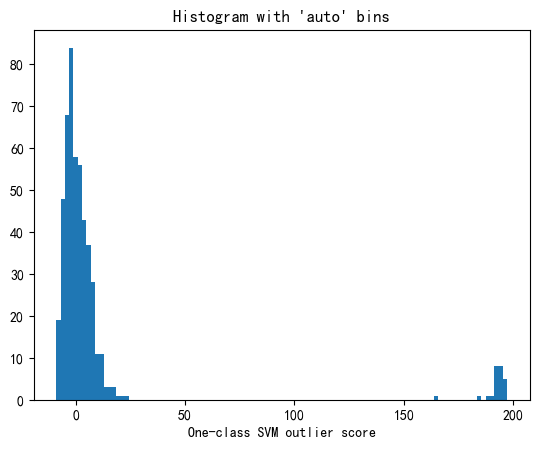

In [18]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('One-class SVM outlier score')
plt.show()

### 描述统计

In [8]:
threshold = ocsvm.threshold_  # Or other value from the above histogram

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal',
                           'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(
        columns={'Anomaly_Score': 'Count'})
    cnt['Count %'] = (cnt['Count'] /
                      cnt['Count'].sum()) * 100  # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index()  # The avg.
    stat = cnt.merge(stat, left_on='Group',
                     right_on='Group')  # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train, y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,0.58
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,192.30


这个指标对于模型评估非常重要。首先，让我们看一下百分比计数。在我们的案例中，它是5%。请记住，异常值组的大小是由阈值确定的。如果选择较高的阈值，它将减小。

其次，让我们检查正常组和异常组的特征均值。希望特征均值与任何先前的领域知识保持一致。例如，如果预期某个特征的均值在异常组中应该更高或更低，而结果相反，则应重新检查或删除该特征。当然，我们也可以使用新的见解来挑战先前的知识。您还需要使用特征名称标记特征，以便有效地展示。

最后，异常组的平均异常分数应该高于正常组的分数。您不需要过多解释分数。

In [9]:
# 混淆矩阵
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### 模型聚合

OCSVM是一种基于相似性的算法，对异常值敏感，容易出现过拟合问题。为了产生一个稳定的模型结果，我们应该建立多个具有不同参数的模型，然后聚合预测结果。

正如前面的章节所述，PyOD模块提供了四种方法来聚合结果：平均值、最大最大值（MOM）、最大平均值（AOM）和平均最大值（MOA）。请记住，您只需要使用一种聚合方法。下面的代码还会对输入数据进行标准化，尽管许多函数会自动进行标准化。

由于nu是最敏感的参数，让我们使用一系列广泛的nu值建立多个模型。总共会有11个模型。我们准备了11列的空数据框来存储这11个模型的预测结果。

In [11]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.ocsvm import OCSVM

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of nu
k_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    ocsvm = OCSVM(nu=k, contamination=0.05)
    ocsvm.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = ocsvm.decision_function(X_train_norm)
    test_scores[:, i] = ocsvm.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

十个模型的预测分数存储在“train_scores”中，并在“train_scores_norm”中进行了归一化。归一化是为了平均这十个预测结果。PyOD模块提供了四种聚合方法。您只需要使用一种方法来生成聚合结果。

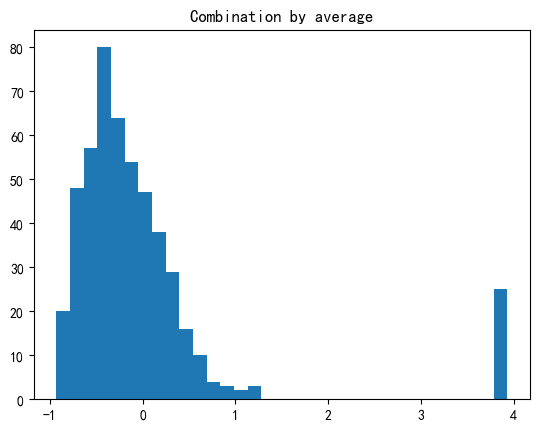

In [12]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

plt.hist(y_train_by_average,
         bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

图中的直方图建议使用1.40作为阈值。我们可以通过聚合分数来推导描述性统计数据。它确定了25个数据点为异常值。

In [13]:
descriptive_stat_threshold(X_train, y_train_by_average, 1.4)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.21
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,3.90


单类支持向量机（OCSVM）模型用于检测不属于正常类别的数据，以建模正常类别的属性。

单类支持向量机（OCSVM）将数据点从原点分离到更高维空间，并最大化该超平面到原点的距离。换句话说，原点是算法试图将其与正常类别分离的类别。

## PCA

### 算法原理

在线性变换中，数据的协方差矩阵被分解为与特征值相关联的正交向量，称为特征向量。特征值是特征向量缩放的因子。具有较高特征值的特征向量捕捉了数据中大部分的方差。“Eigen”是德语单词，意思是“自己”或“典型”。特征向量也可以称为“特征向量”。

当维度降低到几个主要维度时，可以识别出模式，然后揭示出异常值。这种直觉来自于异常值本身。D.M.Hawkins曾经对异常值给出了一个很好的定义：“异常值是与其他观察值相差很大，以至于引起怀疑它是由不同机制生成的观察值。”因为异常值往往遵循不同的规律，它们通常不在前几个主成分中。当它们投影到低维超平面时，它们将落在一些具有较小特征值的唯一特征向量上。我们可以说异常值检测是降维的副产品。具有这个属性的数据点在PCA中的异常值得分如下：

异常值得分 = 每个观察值到所选特征向量构成的超平面的加权欧氏距离之和

在执行PCA之前，对数据进行标准化是必要的。如果对数据进行标准化，所有变量都具有相同的标准差，因此所有变量具有相同的权重。如果忘记对数据进行标准化，具有较高标准差的变量在轴的计算中将具有较高的权重，而具有较低标准差的变量则具有较低的权重。另一种思考标准化需求的方式是，数据集中的不同变量可能具有不同的测量单位。例如，一个变量可能是美元金额，另一个变量可能是单位等。需要对所有变量进行数据标准化。PyOD中的PCA类具有内置的标准化过程。它在执行PCA之前对数据进行标准化。

### 构建模型

In [4]:
from pyod.models.pca import PCA

pca = PCA(contamination=0.05)
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(
    X_train)  # You also can use .decision_function()
y_train_pred = pca.predict(X_train)  # You also can use .decision_function()

y_test_scores = pca.decision_function(
    X_test)  # You also can use .decision_function()
y_test_pred = pca.predict(X_test)  # You also can use .decision_function()

In [5]:
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

label_：这是训练数据的标签向量。如果您使用.predict()训练数据，则相同。

decision_scores_：这是训练数据的分数向量。如果您使用.decision_functions()训练数据，则相同。

decision_score()：此评分函数为每个观察分配异常值分数。

predict()：这是分配1或0的预测函数，基于分配的阈值。

contamination：这是异常值的百分比。在大多数情况下，我们不知道异常值的百分比，因此可以根据任何先前知识分配一个值。 PyOD默认将污染率设置为10％。此参数不影响异常值分数的计算。

在PCA中一个非常重要的指标是解释方差比。它解释了每个主成分解释了多少总方差。PyOD通过其函数.explained_variance_ratio_传递解释方差。下面的输出显示第一个PC解释了73.4%的方差，第二个PC解释了额外的7.4%，第三个解释了5.6%，以此类推。六个主成分的解释方差之和应该为100%。

In [42]:
[pca.explained_variance_, pca.explained_variance_ratio_]

[array([4.13739583, 0.55186189, 0.38712658, 0.34746491, 0.31134247,
        0.27683236]),
 array([0.68818684, 0.09179303, 0.06439205, 0.057795  , 0.05178663,
        0.04604645])]

## GMM

### 算法原理

GMM输出数据点属于不同高斯分布的概率。这个输出成为定义异常值的一种自然方式。那些具有非常低拟合值的数据点被认为是异常值。因为其他算法为异常值定义高异常值分数，为了保持一致，低拟合值被反转为高值作为异常值分数。

### 构建模型

In [43]:
from pyod.models.gmm import GMM

gmm = GMM(n_components=4, contamination=0.05)
gmm.fit(X_train)

# Training data
y_train_scores = gmm.decision_function(X_train)
y_train_pred = gmm.predict(X_train)

# Test data
y_test_scores = gmm.decision_function(X_test)
y_test_pred = gmm.predict(X_test)  # outlier labels (0 or 1)


def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))


print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:", gmm.threshold_)

The training data: {0: 475, 1: 25}
The testing data: {0: 466, 1: 34}
The threshold for the defined comtanimation rate: 4.4212987694440296


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### 模型聚合

In [46]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.gmm import GMM

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of clusters from 2 to 8. There will be 7 models.
n_clf = 7
k_list = [2, 3, 4, 5, 6, 7, 8]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    gmm = GMM(n_components=k)
    gmm.fit(X_train_norm)

    # Store the results in each column:
    test_scores[:, i] = gmm.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

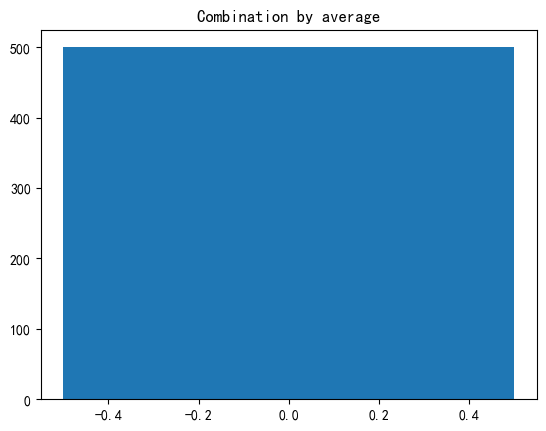

In [47]:
# Combination by average
# The test_scores_norm is 500 x 7. The "average" function will take the average of the 7 columns.
# The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt

plt.hist(y_train_by_average,
         bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

GMM用于描述数据点来自不同分布的概率，而K-means将数据点识别为一个且仅一个簇。

条件概率p(z|x)的含义是“给定一个数据点x，它属于z的概率是p(z|x)”。通过使用贝叶斯定理，我们可以得到后验概率p(z|x)。

GMM使用期望最大化算法来找到后验概率p(z|x)的最优值。E步骤为数据点属于某个分布的概率分配一个初始“猜测”。给定这个猜测，可以进行最大似然估计。M步骤是标准的最大似然估计来估计参数。新的参数被传递给E步骤再次分配后验概率。E步骤和M步骤将迭代重复直到收敛。

那些与基础高斯分布拟合值较低的数据点被认为是异常值。